In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Embedding, GRU, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import pad_sequences
from keras.datasets import imdb

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.metrics import categorical_accuracy

from sklearn.metrics import confusion_matrix
from sklearn. preprocessing import normalize

### __Допоміжні функції та класи__ (сильно не бити що не виніс в окремий файл) ### 

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)


set_seed(42)

In [14]:
def get_checkpoint_callback(filename: str, verbose: int=0) -> ModelCheckpoint:
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=filename,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=verbose)


def loss_accuracy_plotting(history: dict, title: str=None, title_y=1.1):
    num_epochs = len(history[list(history.keys())[0]])

    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, max(1, num_epochs//10))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2})

    ax1.plot(x, history["loss"])
    ax1.plot(x, history["val_loss"])
    ax1.set_title("loss and val_loss")

    ax2.plot(x, history["accuracy"])
    ax2.plot(x ,history["val_accuracy"])
    ax2.set_title("accuracy and val_accuracy")

    ax1.grid(True)
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")

    ax2.grid(True)
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")

    ax1.legend(["loss", "val_los"])
    ax2.legend(["accuracy", "val_accuracy"])

    if title:
        fig.suptitle(title, y=title_y)
    plt.show()


def multi_val_loss_accuracy_plotting(val_loss: dict, val_accuracy: dict, title: str=None, title_y=1):
    num_epochs = len(val_loss[list(val_loss.keys())[0]])
    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, max(1, num_epochs//10))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2, "hspace": 0.4})

    for i in range(len(val_loss)):
        ax1.plot(x, val_loss[list(val_loss.keys())[i]])
        ax2.plot(x, val_accuracy[list(val_accuracy.keys())[i]])

    ax1.set_title("val_loss")
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")
    ax1.grid(True)
    ax2.set_title("val_accuracy")
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")
    ax2.grid(True)

    ax1.legend(val_loss.keys())
    ax2.legend(val_accuracy.keys())

    if title:
        fig.suptitle(title, y=title_y)
    plt.show()

In [4]:
class InputData:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test


class HyperParameters:
    def __init__(self, batch_size:int = 200, n_epochs = 10, optimizer=None):
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.optimizer = optimizer if optimizer else Adam(learning_rate=0.0006)


class RnnModel:
    def __init__(self, layers: list, hp: HyperParameters):
        self.history = {}

        self.batch_size = hp.batch_size
        self.n_epochs = hp.n_epochs
        self.optimizer = hp.optimizer

        self.model = Sequential()
        for layer in layers:
            self.model.add(layer)
        self.model.compile(optimizer=self.optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    def evaluate(self, data:InputData):
        if self.history:
            score_train = self.model.evaluate(data.x_train, data.y_train, verbose=0)
            score_test = self.model.evaluate(data.x_test, data.y_test, verbose=0)
            print(f"Train loss: {score_train[0]}, train accuracy: {score_train[1]}")
            print(f"Test loss:  {score_test[0]}, test accuracy:  {score_test[1]}")

            print("\nTrain")
            print(f"Min loss : {np.array(self.history['loss']).min()}, "
                  f"epoch num: {np.argmin(self.history['loss']) + 1}")
            print(f"Max accuracy : {np.array(self.history['accuracy']).max()}, "
                  f"epoch num: {np.argmax(self.history['accuracy']) + 1}")
            print("\nValidation")
            print(f"Min loss : {np.array(self.history['val_loss']).min()}, "
                  f"epoch num: {np.argmin(self.history['val_loss']) + 1}")
            print(f"Max accuracy : {np.array(self.history['val_accuracy']).max()}, "
                  f"epoch num: {np.argmax(self.history['val_accuracy']) + 1}")

    def fit(self, data:InputData, callbacks=None, verbose=0) -> dict:
        self.history = (self.model.fit(data.x_train, data.y_train, batch_size=self.batch_size,
                                       epochs=self.n_epochs, callbacks=callbacks,
                                       validation_split=0.20, verbose=verbose)).history

    def summary(self, verbose=0):
        if verbose:
            self.model.summary()
        else:
            trainable_params = np.sum([np.prod(v.get_shape()) for v in self.model.trainable_weights])
            non_trainable_params = np.sum([np.prod(v.get_shape()) for v in self.model.non_trainable_weights])
            total_params = trainable_params + non_trainable_params
            print("="*60)
            print(f"Total params: {int(total_params)}")
            print(f"Trainable params: {int(trainable_params)}")
            print(f"Non-trainable params: {int(non_trainable_params)}")
            print("_"*60)

### __Підготовка данних__ ###

In [5]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

maxlen = 300  # обмеження кількості слів в тексті
max_features = 10000

input_train = pad_sequences(train_data, maxlen=maxlen)
input_test = pad_sequences(test_data, maxlen=maxlen)
imdb_data = InputData(input_train, train_labels, input_test.astype("int32"), test_labels.astype("int32"))

17464789/17464789 [==============================] - 2s 0us/step


### __GRU__ ###

In [47]:
gru_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    GRU(64, dropout=0.8),
    Dense(1, activation="sigmoid"),
]
optimizer = Adam(learning_rate=0.0006)
model = RnnModel(gru_layers, HyperParameters(n_epochs=15, optimizer=optimizer))
model.summary(verbose=0)

Total params: 175809
Trainable params: 175809
Non-trainable params: 0
____________________________________________________________


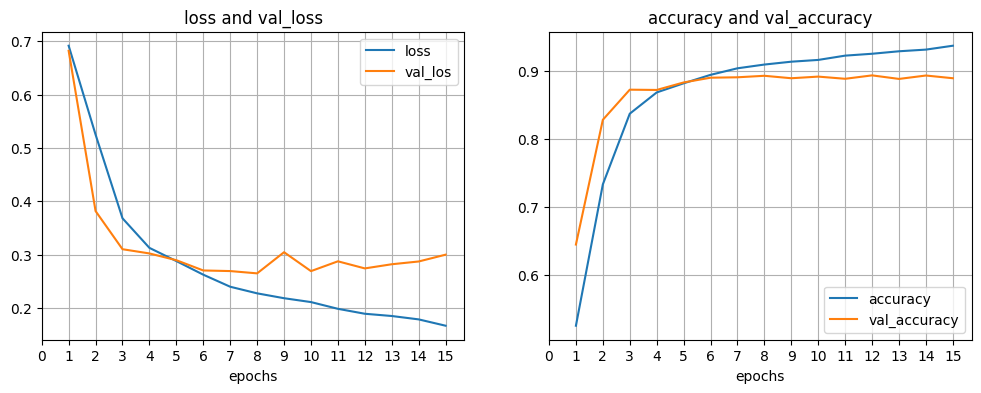

In [48]:
checkpoint_callback = get_checkpoint_callback("model/gru_model", verbose=0)
model.fit(imdb_data, callbacks=[checkpoint_callback], verbose=0)
loss_accuracy_plotting(model.history)

__Бачимо, що трохи рано стартує перенавчання, тому збільшуємо dropout до 0.9, хоч це вже виглядає якось дивнувато__

In [16]:
gru_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    GRU(64, dropout=0.9),  # дропоут 0,9 це вже якийсь сюр, але
    Dense(1, activation="sigmoid"),
]
optimizer = Adam(learning_rate=0.0006)
model = RnnModel(gru_layers, HyperParameters(n_epochs=15, optimizer=optimizer))
model.summary(verbose=0)

Total params: 175809
Trainable params: 175809
Non-trainable params: 0
____________________________________________________________


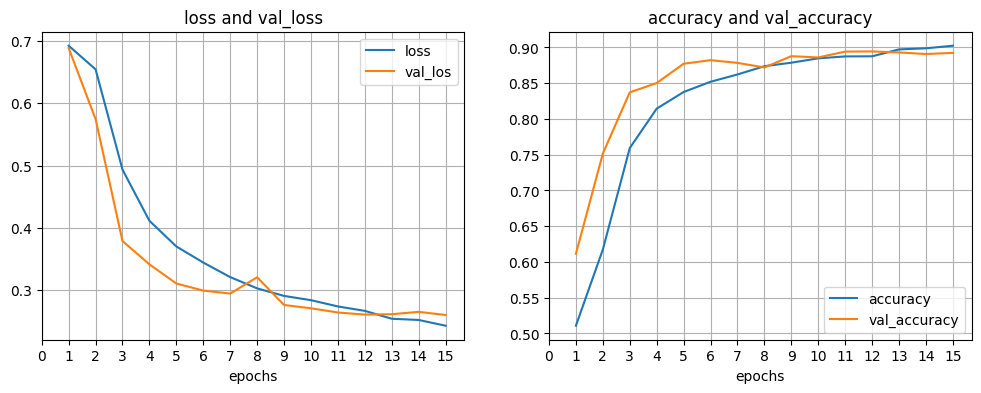

In [17]:
checkpoint_callback = get_checkpoint_callback("model/gru_model")
model.fit(imdb_data, callbacks=[checkpoint_callback])
loss_accuracy_plotting(model.history)

In [18]:
model.model.load_weights("model/gru_model")
model.evaluate(imdb_data)

Train loss: 0.17120712995529175, train accuracy: 0.9366000294685364
Test loss:  0.2745416760444641, test accuracy:  0.8853600025177002

Train
Min loss : 0.24301601946353912, epoch num: 15
Max accuracy : 0.902400016784668, epoch num: 15

Validation
Min loss : 0.2602494955062866, epoch num: 15
Max accuracy : 0.8944000005722046, epoch num: 12


__Фіксуємо незначне покращення значень та меньш ломані графіки помилки та точності ніж в простої RNN моделі__

### __LSTM__ ###

In [25]:
lstm_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    LSTM(64, dropout=0.9),
    Dense(1, activation="sigmoid"),
]
model = RnnModel(lstm_layers, HyperParameters(n_epochs=15))
model.summary(verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 16)           160000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                20736     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 180,801
Trainable params: 180,801
Non-trainable params: 0
_________________________________________________________________


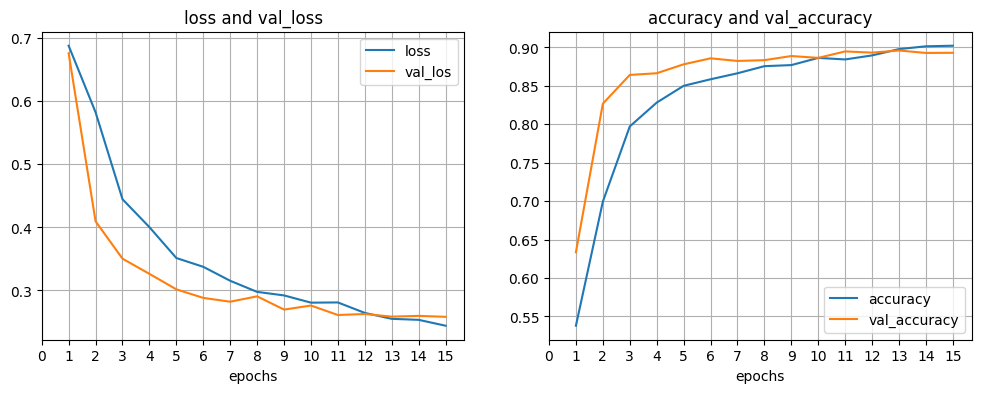

In [26]:
checkpoint_callback = get_checkpoint_callback("model/lstm_model")
model.fit(imdb_data, callbacks=[checkpoint_callback])
loss_accuracy_plotting(model.history)

In [27]:
model.model.load_weights("model/lstm_model")
model.evaluate(imdb_data)

Train loss: 0.17415110766887665, train accuracy: 0.9364799857139587
Test loss:  0.2721697688102722, test accuracy:  0.8889600038528442

Train
Min loss : 0.24404306709766388, epoch num: 15
Max accuracy : 0.9021999835968018, epoch num: 15

Validation
Min loss : 0.2581693232059479, epoch num: 15
Max accuracy : 0.8960000276565552, epoch num: 13


__Поки найкращий результат__

In [28]:
model.model.save("model/best_lstm_model")

### __BRNN (BLSTM)__ ###

In [29]:
bi_lstm_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    Bidirectional(LSTM(64, dropout=0.9)),
    Dense(1, activation="sigmoid"),
]
optimizer = Adam(learning_rate=0.0006)
model = RnnModel(bi_lstm_layers, HyperParameters(n_epochs=15, optimizer=optimizer))
model.summary(verbose=0)

Total params: 201601
Trainable params: 201601
Non-trainable params: 0
____________________________________________________________


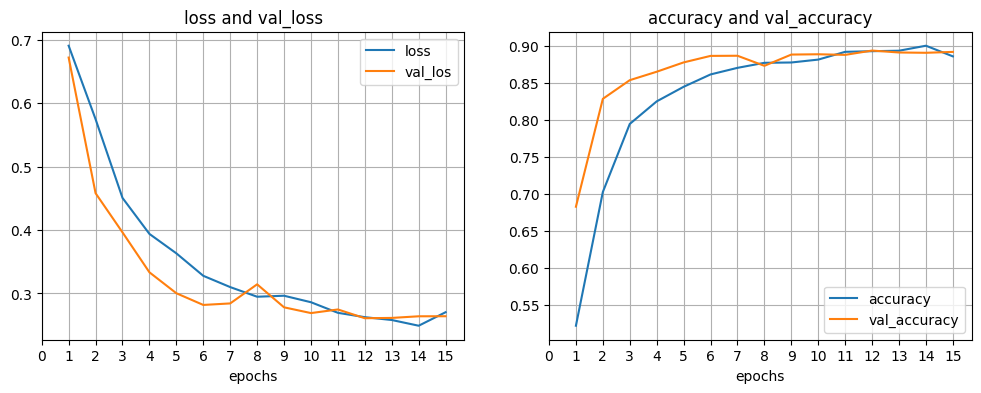

In [30]:
checkpoint_callback = get_checkpoint_callback("model/bi_lstm_model")
model.fit(imdb_data, callbacks=[checkpoint_callback], verbose=0)
loss_accuracy_plotting(model.history)

In [31]:
model.model.load_weights("model/bi_lstm_model")
model.evaluate(imdb_data)

Train loss: 0.19055475294589996, train accuracy: 0.9323599934577942
Test loss:  0.2742275297641754, test accuracy:  0.885919988155365

Train
Min loss : 0.24907827377319336, epoch num: 14
Max accuracy : 0.9007499814033508, epoch num: 14

Validation
Min loss : 0.2608966827392578, epoch num: 12
Max accuracy : 0.8942000269889832, epoch num: 12


__Ранувато перенавчання, але цого разу зменшимо LR__

In [32]:
bi_lstm_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    Bidirectional(LSTM(64, dropout=0.9)),
    Dense(1, activation="sigmoid"),
]
optimizer = Adam(learning_rate=0.0005)
model = RnnModel(bi_lstm_layers, HyperParameters(n_epochs=15, optimizer=optimizer))
model.summary(verbose=0)


Total params: 201601
Trainable params: 201601
Non-trainable params: 0
____________________________________________________________


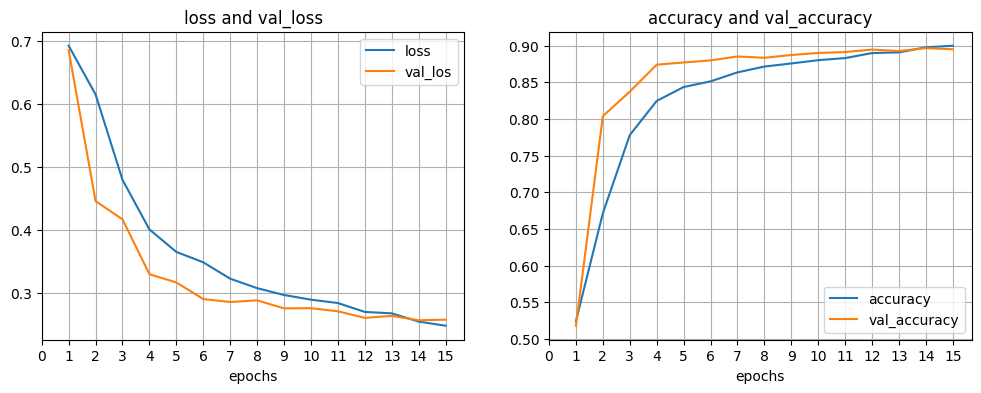

In [33]:
checkpoint_callback = get_checkpoint_callback("model/bi_lstm_model")
model.fit(imdb_data, callbacks=[checkpoint_callback], verbose=0)
loss_accuracy_plotting(model.history)

In [34]:
model.model.load_weights("model/bi_lstm_model")
model.evaluate(imdb_data)

Train loss: 0.18355685472488403, train accuracy: 0.9338799715042114
Test loss:  0.27074089646339417, test accuracy:  0.887440025806427

Train
Min loss : 0.24760524928569794, epoch num: 15
Max accuracy : 0.8998500108718872, epoch num: 15

Validation
Min loss : 0.2562996745109558, epoch num: 14
Max accuracy : 0.8966000080108643, epoch num: 14


__Зміна точності в рамках статистичної похибки__

### __DRNN__ ###

Тут відразу довелося ще трохи зменшити LR та збільшити кількість епох

In [41]:
deep_lstm_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    LSTM(64, dropout=0.9, return_sequences=True),
    LSTM(64, dropout=0.9),
    Dense(1, activation="sigmoid"),
]
optimizer = Adam(learning_rate=0.0004)
model = RnnModel(deep_lstm_layers, HyperParameters(n_epochs=20, optimizer=optimizer))
model.summary(verbose=0)

Total params: 213825
Trainable params: 213825
Non-trainable params: 0
____________________________________________________________


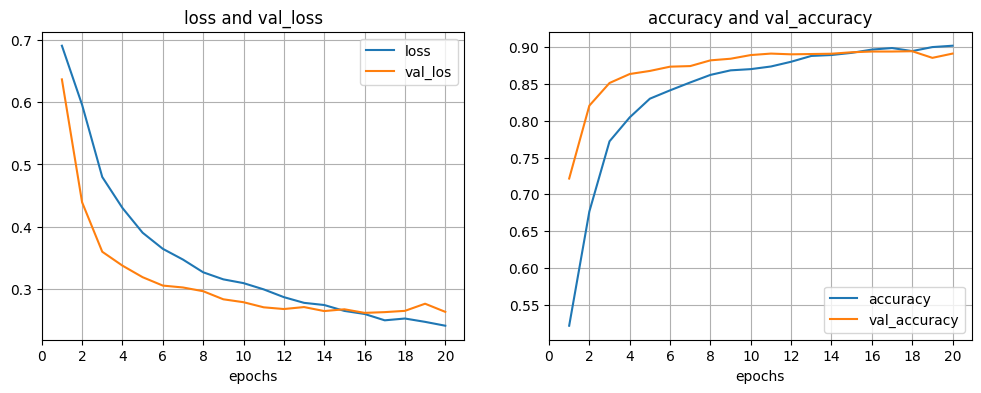

In [42]:
checkpoint_callback = get_checkpoint_callback("model/deep_lstm_model")
model.fit(imdb_data, callbacks=[checkpoint_callback], verbose=0)
loss_accuracy_plotting(model.history)

In [43]:
model.model.load_weights("model/deep_lstm_model")
model.evaluate(imdb_data)

Train loss: 0.18321888148784637, train accuracy: 0.9348000288009644
Test loss:  0.27537500858306885, test accuracy:  0.8865600228309631

Train
Min loss : 0.24151679873466492, epoch num: 20
Max accuracy : 0.9021000266075134, epoch num: 20

Validation
Min loss : 0.26210126280784607, epoch num: 16
Max accuracy : 0.894599974155426, epoch num: 18


__вирішив ще спрбувати зі збільшеним batch_size=500__

In [44]:
deep_lstm_layers = [
    Embedding(max_features, 16, input_length=maxlen),
    LSTM(64, dropout=0.9, return_sequences=True),
    LSTM(64, dropout=0.9),
    Dense(1, activation="sigmoid"),
]
optimizer = Adam(learning_rate=0.0004)
model = RnnModel(deep_lstm_layers, HyperParameters(n_epochs=20, batch_size=500, optimizer=optimizer))
model.summary(verbose=0)

Total params: 213825
Trainable params: 213825
Non-trainable params: 0
____________________________________________________________


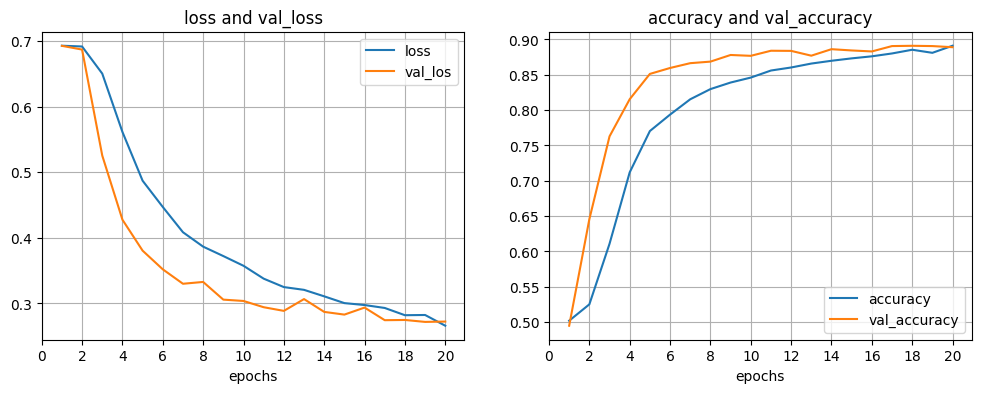

In [45]:
checkpoint_callback = get_checkpoint_callback("model/deep_lstm_model_1")
model.fit(imdb_data, callbacks=[checkpoint_callback], verbose=0)
loss_accuracy_plotting(model.history)

In [46]:
model.model.load_weights("model/deep_lstm_model_1")
model.evaluate(imdb_data)

Train loss: 0.2066018432378769, train accuracy: 0.9271199703216553
Test loss:  0.28024619817733765, test accuracy:  0.8862800002098083

Train
Min loss : 0.26594263315200806, epoch num: 20
Max accuracy : 0.8910999894142151, epoch num: 20

Validation
Min loss : 0.27176499366760254, epoch num: 19
Max accuracy : 0.890999972820282, epoch num: 18


__Результат непоганий, але довше навчається. Звертаємо увагу на маленьку дельту між val та test accracy = 0,0047__

### __Ну і по традиції матриця помилок__ ###

In [49]:
best_model = keras.models.load_model("model/best_lstm_model")

In [50]:
best_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 16)           160000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                20736     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 180,801
Trainable params: 180,801
Non-trainable params: 0
_________________________________________________________________


782/782 [==============================] - 4s 5ms/step


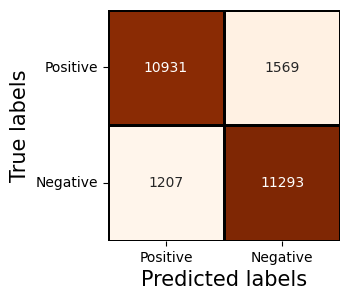

True Positive: 10931
True Negative: 11293
False Positive: 1569
False Negative: 1207


In [53]:
y_pred = best_model.predict(imdb_data.x_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(imdb_data.y_test, y_pred)

labels = ["Positive", "Negative"]

df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(3, 3))
sns.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);
plt.show()

print ("True Positive:" , (cm[0,0]))
print ("True Negative:" , (cm[1,1]))
print ("False Positive:" , (cm[0,1]))
print ("False Negative:" , (cm[1,0]))

## __Висновок__ ##

__Вцілому, якщо нічого не знати про трансформери, то протестовані рекурентні мережі непогано справилися з завданням класифікації рецензій із датасету imdb. Більш продвинуті архітектури хоч і не суттєво але переважають SIMPLE RNN.__  
__Показники точності:__
- Simle RNN.......0.8811
- GRU.................0.8854
- LSTM...............0.889
- BRNN..............0.8859
- DRNN..............0.8863

## __PS__ ##

__Спробував відтворити приклад лектора з трансформером і досягнув на двух епохах:__  
[3126/3126 51:07, Epoch 2/2]  
Epoch 	Training Loss 	Validation Loss 	Accuracy  
1 	    0.225900 	0.259195 	0.903440  
2 	    0.158800 	0.226305 	0.932760

TrainOutput(global_step=3126, training_loss=0.207386352431675, metrics={'train_runtime': 3071.5511, 'train_samples_per_second': 16.278, 'train_steps_per_second': 1.018, 'total_flos': 6564686875195392.0, 'train_loss': 0.207386352431675, 'epoch': 2.0})

__Виглядає значно краще.__